In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

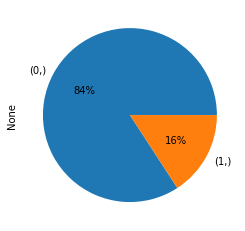

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

In [4]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [5]:
train.dtypes.value_counts()

float64    1048
int32        65
int64        23
dtype: int64

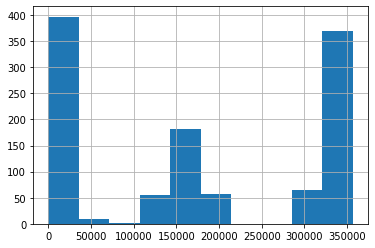

In [6]:
train.isna().sum().hist();

## Entrenando LGBM con hiperparámetros

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.856936	training's binary_logloss: 0.292239	valid_1's auc: 0.84233	valid_1's binary_logloss: 0.303186
[200]	training's auc: 0.872172	training's binary_logloss: 0.280473	valid_1's auc: 0.846739	valid_1's binary_logloss: 0.299657
[300]	training's auc: 0.882948	training's binary_logloss: 0.271993	valid_1's auc: 0.847878	valid_1's binary_logloss: 0.298809
Early stopping, best iteration is:
[327]	training's auc: 0.885625	training's binary_logloss: 0.269881	valid_1's auc: 0.848044	valid_1's binary_logloss: 0.29871
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.856927	training's binary_logloss: 0.292188	valid_1's auc: 0.841971	valid_1's binary_logloss: 0.303186
[200]	training's auc: 0.871942	training's binary_logloss: 0.280424	valid_1's auc: 0.84622	valid_1's binary_logloss: 0.2999
[300]	training's auc: 0.882858	training's bi

In [8]:
fi.sort_values(ascending=False).head(50)

RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.012606
cod_instit_financiera_max_ult1mes                    0.011581
edad                                                 0.010365
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.008857
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.008844
ubigeo_mode                                          0.008489
RIESGO_DIRECTO_-1_saldoUnique_ult12meses             0.008307
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.008029
cod_instit_financiera_mode_ult1mes                   0.006738
RIESGO_DIRECTO_1_saldoMin_ult1meses                  0.006509
cod_instit_financiera_min_ult1mes                    0.006308
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.006118
tipo_credito_11_saldoStd_ult1meses                   0.005895
RIESGO_DIRECTO_1_saldoMedian_ult1meses               0.005428
sexo_0                                               0.005401
condicion_0_saldoUnique_ult12meses                   0.005325
ciiu_mod

In [9]:
fi.to_pickle('fi_lightgbm.pkl')

In [10]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Entrenando CatBoost con hiperparámetros
### CatBoostClassifier(boosting_type = 'Plain', n_estimators=1000, eval_metric = 'AUC', colsample_bylevel=1, subsample=1, learning_rate=0.3)

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(boosting_type = 'Plain', n_estimators=1000, eval_metric = 'AUC',
                   colsample_bylevel=1, subsample=1, learning_rate=0.3)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
0:	test: 0.7093593	test1: 0.7108453	best: 0.7108453 (0)	total: 689ms	remaining: 11m 28s
100:	test: 0.8504688	test1: 0.8395184	best: 0.8396107 (98)	total: 1m 10s	remaining: 10m 24s
200:	test: 0.8647001	test1: 0.8428050	best: 0.8428050 (200)	total: 2m 19s	remaining: 9m 16s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8431052276
bestIteration = 212

Shrink model to first 213 iterations.
********** 1 **********
0:	test: 0.7269500	test1: 0.7250728	best: 0.7250728 (0)	total: 736ms	remaining: 12m 15s
100:	test: 0.8508043	test1: 0.8398558	best: 0.8399836 (97)	total: 1m 18s	remaining: 11m 43s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8420045373
bestIteration = 146

Shrink model to first 147 iterations.
********** 2 **********
0:	test: 0.7064753	test1: 0.7146973	best: 0.7146973 (0)	total: 620ms	remaining: 10m 19s
100:	test: 0.8505039	test1: 0.8429398	best: 0.8429398 (100)	total: 1m 15s	remaining: 11m 16s
Stopped by overfitt

In [12]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses        0.186305
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult5meses     0.024312
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.020085
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.017645
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.017080
RIESGO_DIRECTO_2_saldoSum_ult1meses                  0.014715
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult1meses     0.013940
RIESGO_DIRECTO_-1_saldoMean_ult2meses                0.013577
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult2meses     0.013110
edad                                                 0.012706
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.012445
COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult4meses     0.011704
cod_instit_financiera_mode_ult1mes                   0.009994
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.009545
condicion_0_saldoUnique_ult12meses                   0.009164
cod_instit_financiera_max_ult1mes                    0.008974
sexo_0  

In [13]:
fi.to_pickle('fi_catboost.pkl')

In [14]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Catboost con parametros casi estandares
### CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)

In [21]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7347704	test1: 0.7368052	best: 0.7368052 (0)	total: 676ms	remaining: 11m 15s
100:	test: 0.8376572	test1: 0.8333426	best: 0.8333464 (99)	total: 56.9s	remaining: 8m 26s
200:	test: 0.8495404	test1: 0.8404734	best: 0.8404734 (200)	total: 1m 52s	remaining: 7m 29s
300:	test: 0.8575553	test1: 0.8432793	best: 0.8432793 (300)	total: 2m 48s	remaining: 6m 30s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8442065855
bestIteration = 374

Shrink model to first 375 iterations.
********** 1 **********
Learning rate set to 0.128212
0:	test: 0.7303746	test1: 0.7309521	best: 0.7309521 (0)	total: 525ms	remaining: 8m 44s
100:	test: 0.8379339	test1: 0.8334550	best: 0.8334550 (100)	total: 1m 2s	remaining: 9m 12s
200:	test: 0.8499308	test1: 0.8402348	best: 0.8402348 (200)	total: 1m 48s	remaining: 7m 11s
300:	test: 0.8571040	test1: 0.8426885	best: 0.8426885 (300)	total: 2m 33s	remaining: 5m 57s
400:	test: 0.8632856	test1: 0.

In [23]:
fi.to_pickle('fi_catboost_v2.pkl')

In [24]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost_v2.pkl')
test_probs_catboost.to_pickle('test_probs_catboost_v2.pkl')

## LGBM con Categorical_Feature con hiperparámetros

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [15]:
var_mode = [ i for i in train.columns if 'mode' in i ]
for i in var_mode:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                             colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50) 
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853018	training's binary_logloss: 0.297856	valid_1's auc: 0.83479	valid_1's binary_logloss: 0.309108
[100]	training's auc: 0.86851	training's binary_logloss: 0.284755	valid_1's auc: 0.841822	valid_1's binary_logloss: 0.303217
[150]	training's auc: 0.878911	training's binary_logloss: 0.276473	valid_1's auc: 0.844192	valid_1's binary_logloss: 0.301272
[200]	training's auc: 0.887114	training's binary_logloss: 0.269921	valid_1's auc: 0.84546	valid_1's binary_logloss: 0.300323
Early stopping, best iteration is:
[200]	training's auc: 0.887114	training's binary_logloss: 0.269921	valid_1's auc: 0.84546	valid_1's binary_logloss: 0.300323
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853105	training's binary_logloss: 0.297583	valid_1's auc: 0.83342	valid_1's binary_logloss: 0.309619
[100]	training's auc: 0.868977	training's binary_logloss: 0.284423	val

In [17]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.113727
cod_instit_financiera_mode_ult1mes                   0.048391
ubigeo_mode                                          0.047601
cod_instit_financiera_mode_ult12mes                  0.028814
cod_instit_financiera_mode_ult2mes                   0.026436
cod_instit_financiera_mode_ult3mes                   0.019045
cod_instit_financiera_mode_ult11mes                  0.018853
cod_instit_financiera_mode_ult4mes                   0.016344
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.014236
cod_instit_financiera_mode_ult10mes                  0.013086
cod_instit_financiera_mode_ult5mes                   0.013068
cod_instit_financiera_mode_ult8mes                   0.012467
cod_instit_financiera_mode_ult6mes                   0.011805
cod_instit_financiera_mode_ult9mes                   0.011791
cod_instit_financiera_mode_ult7mes                   0.011316
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.009576
edad    

In [18]:
fi.to_pickle('fi_lightgbm_cf.pkl')

In [19]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_lightgbm_cf.pkl')

## Entrenamiento de modelo XgBoost

In [7]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') 
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [8]:
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = XGBClassifier(n_estimators=1000, booster='gbtree', colsample_bytree=0.8, 
                            subsample = 0.8, max_depth=4,  learning_rate=0.3)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.71377	validation_1-auc:0.71278
[100]	validation_0-auc:0.85797	validation_1-auc:0.84055
[166]	validation_0-auc:0.86916	validation_1-auc:0.84218
********** 1 **********
[0]	validation_0-auc:0.71254	validation_1-auc:0.71216
[100]	validation_0-auc:0.85818	validation_1-auc:0.84030
[141]	validation_0-auc:0.86585	validation_1-auc:0.84120
********** 2 **********
[0]	validation_0-auc:0.71196	validation_1-auc:0.71516
[100]	validation_0-auc:0.85856	validation_1-auc:0.84255
[123]	validation_0-auc:0.86263	validation_1-auc:0.84295
********** 3 **********
[0]	validation_0-auc:0.71033	validation_1-auc:0.71230
[100]	validation_0-auc:0.85799	validation_1-auc:0.84265
[160]	validation_0-auc:0.86852	validation_1-auc:0.84364
********** 4 **********
[0]	validation_0-auc:0.71385	validation_1-auc:0.69850
[100]	validation_0-auc:0.85998	validation_1-auc:0.83431
[109]	validation_0-auc:0.86164	validation_1-auc:0.83415
*********************
roc auc estimado:  0.8409848198898145
roc auc varian

In [9]:
fi.to_pickle('fi_xgb.pkl')

In [10]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_xgb.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_xgb.pkl')

## Entrenando Neural Network Artificial

In [7]:
train = pd.read_pickle('../data/train_score_0.84862.pkl')
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [8]:
#### eliminar variable cuyo porcentaje de valores nulos es mayor al 90%
aux = train.isna().sum()/len(train)
drop_columns = list(aux[aux>=0.9].index)
train.drop(drop_columns, axis=1, inplace=True)
test.drop(drop_columns, axis=1, inplace=True)
train.shape, test.shape

((358487, 783), (396666, 783))

In [9]:
fi = pd.read_pickle('fi_lightgbm.pkl')
fi.loc[train.columns].sum()

0.840152977675237

In [10]:
var_missing_values = list(train.isna().sum()[train.isna().sum()>0].index)
len(var_missing_values)

625

In [11]:
var_mode =[i for i in var_missing_values if "mode" in i]
var_std =[i for i in var_missing_values if "Std" in i or "std" in i]
var_unique =[i for i in var_missing_values if "Unique" in i or "unique" in i ]
var_mean =[i for i in var_missing_values if "Mean" in i or "mean" in i]
var_median =[i for i in var_missing_values if "Median" in i or "median" in i]
var_sum =[i for i in var_missing_values if "Sum" in i or "sum" in i]
var_max =[i for i in var_missing_values if "Max" in i or "max" in i]
var_min =[i for i in var_missing_values if "Min" in i or "min" in i]
len(var_mode), len(var_std), len(var_unique), len(var_mean), len(var_median), len(var_sum),len(var_max), len(var_min)

(14, 88, 97, 81, 84, 82, 78, 70)

In [12]:
var_total = var_mode+var_std+var_unique+var_mean+var_median+var_sum+var_max+var_min
var_rest = list(set(var_missing_values).difference(var_total))
len(set(var_total)), len(set(var_rest))

(594, 31)

#### imputacion tradicional

In [13]:
for i in var_mode:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0])
for i in var_std:
    train[i] = train[i].fillna(0)   
    test[i] = test[i].fillna(0)   
for i in var_unique:
    train[i] = train[i].fillna(0)   
    test[i] = test[i].fillna(0)   
for i in var_mean:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_median:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_sum:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_max:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_min:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_rest:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   

In [14]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.models import load_model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import Callback

In [15]:
def get_one_hot(y_train):
    one_hot =[]
    for i in y_train.values:
        aux=[]
        for j in [0,1]:
            if i==j:
                aux.append(1)
            else:
                aux.append(0)
        one_hot.append(aux)
    return  np.array(one_hot)

In [16]:
def get_model_keras(one_hot):
    model_rnn = Sequential()
    model_rnn.add(Dense(128,input_dim=len(train.columns),activation="relu"))
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid")) # sigmoid
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#     sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
    model_rnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['AUC'])
    return model_rnn

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [18]:
train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

In [27]:
# https://keras.rstudio.com/reference/fit.html
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]
    yt = get_one_hot(yt)

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]
    yv = get_one_hot(yv)
    
    learner = get_model_keras(yv)
    
    num_epochs = 100
    num_batch_size = 1024
#     num_steps_per_epoch = len(Xt)//batch_size      steps_per_epoch = num_steps_per_epoch
    num_validation_steps = 10
    learner.fit(Xt, yt ,epochs=num_epochs, batch_size=num_batch_size, 
                        validation_steps=num_validation_steps)    
    
    test_probs.append(pd.Series(learner.predict(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict(Xv)[:, -1], index=Xv.index, name="probs"))
    print(f'roc_auc estimado en fold {i} : {roc_auc_score(yv[:,-1],learner.predict(Xv)[:,-1])}')
#     fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
# fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********
Epoch 1/100
281/281 [==============================] - 3s 10ms/step - loss: 0.4339 - auc: 0.8822
Epoch 2/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3446 - auc: 0.9259
Epoch 3/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3365 - auc: 0.9287
Epoch 4/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3329 - auc: 0.9298
Epoch 5/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3307 - auc: 0.9310
Epoch 6/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3291 - auc: 0.9322
Epoch 7/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3294 - auc: 0.9321
Epoch 8/100
281/281 [==============================] - 3s 10ms/step - loss: 0.3261 - auc: 0.9328
Epoch 9/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3241 - auc: 0.9334
Epoch 10/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3219 - auc: 0.9342
Epoch

281/281 [==============================] - 3s 12ms/step - loss: 0.3131 - auc: 0.9391
Epoch 85/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3155 - auc: 0.9382
Epoch 86/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3182 - auc: 0.9388
Epoch 87/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3155 - auc: 0.9383
Epoch 88/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3112 - auc: 0.9396
Epoch 89/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3143 - auc: 0.9391
Epoch 90/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3110 - auc: 0.9393
Epoch 91/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3157 - auc: 0.9387
Epoch 92/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3107 - auc: 0.9392
Epoch 93/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3110 - auc: 0.9394
Epoch 94/100
281/281 [===========

281/281 [==============================] - 3s 12ms/step - loss: 0.3142 - auc: 0.9387
Epoch 68/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3130 - auc: 0.9391
Epoch 69/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3142 - auc: 0.9388
Epoch 70/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3180 - auc: 0.9383
Epoch 71/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3112 - auc: 0.9397
Epoch 72/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3171 - auc: 0.9377
Epoch 73/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3136 - auc: 0.9388
Epoch 74/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3135 - auc: 0.9394
Epoch 75/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3184 - auc: 0.9384
Epoch 76/100
281/281 [==============================] - 3s 11ms/step - loss: 0.3216 - auc: 0.9395
Epoch 77/100
281/281 [===========

281/281 [==============================] - 3s 12ms/step - loss: 0.3239 - auc: 0.9365
Epoch 51/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3168 - auc: 0.9381
Epoch 52/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3208 - auc: 0.9384
Epoch 53/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3174 - auc: 0.9377
Epoch 54/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3139 - auc: 0.9378
Epoch 55/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3201 - auc: 0.9372
Epoch 56/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3149 - auc: 0.9380
Epoch 57/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3152 - auc: 0.9382
Epoch 58/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3194 - auc: 0.9380
Epoch 59/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3164 - auc: 0.9379
Epoch 60/100
281/281 [===========

281/281 [==============================] - 3s 12ms/step - loss: 0.3200 - auc: 0.9364
Epoch 33/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3194 - auc: 0.9367
Epoch 34/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3212 - auc: 0.9369
Epoch 35/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3207 - auc: 0.9373
Epoch 36/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3165 - auc: 0.9377
Epoch 37/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3217 - auc: 0.9366
Epoch 38/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3160 - auc: 0.9377
Epoch 39/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3162 - auc: 0.9377
Epoch 40/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3215 - auc: 0.9364
Epoch 41/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3255 - auc: 0.9373
Epoch 42/100
281/281 [===========

281/281 [==============================] - 4s 13ms/step - loss: 0.3251 - auc: 0.9345
Epoch 16/100
281/281 [==============================] - 4s 12ms/step - loss: 0.3264 - auc: 0.9348
Epoch 17/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3218 - auc: 0.9352
Epoch 18/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3222 - auc: 0.9361
Epoch 19/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3210 - auc: 0.9358
Epoch 20/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3253 - auc: 0.9356
Epoch 21/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3167 - auc: 0.9370
Epoch 22/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3185 - auc: 0.9364
Epoch 23/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3190 - auc: 0.9365
Epoch 24/100
281/281 [==============================] - 4s 13ms/step - loss: 0.3201 - auc: 0.9369
Epoch 25/100
281/281 [===========

281/281 [==============================] - 3s 12ms/step - loss: 0.3124 - auc: 0.9393
Epoch 99/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3160 - auc: 0.9400
Epoch 100/100
281/281 [==============================] - 3s 12ms/step - loss: 0.3110 - auc: 0.9401
roc_auc estimado en fold 4 : 0.8255343171594599
*********************
roc auc estimado:  0.8298009311291774
roc auc varianza:  0.0009551435622209993


In [ ]:
########     num_batch_size = 512   
###  num_epochs = 7   0.818
###  num_epochs = 15  0.82300
###  num_epochs = 30  0.82598
###  num_epochs = 50  0.82720 , num_batch_size = 1028 
###  num_epochs = 50   0.829800 , num_batch_size = 1028 

In [28]:
train_probs_rnn = train_probs
test_probs_rnn = test_probs
train_probs_rnn.to_pickle('train_probs_rnn.pkl')
test_probs_rnn.to_pickle('test_probs_rnn.pkl')

## Entrenando RandomForest

In [37]:
train = pd.read_pickle('../data/train_score_0.84862.pkl')
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [38]:
# #### eliminar variable cuyo porcentaje de valores nulos es mayor al 90%
# aux = train.isna().sum()/len(train)
# drop_columns = list(aux[aux>=0.9].index)
# train.drop(drop_columns, axis=1, inplace=True)
# test.drop(drop_columns, axis=1, inplace=True)
# train.shape, test.shape

In [39]:
var_missing_values = list(train.isna().sum()[train.isna().sum()>0].index)
len(var_missing_values)

978

In [40]:
var_mode =[i for i in var_missing_values if "mode" in i]
var_std =[i for i in var_missing_values if "Std" in i or "std" in i]
var_unique =[i for i in var_missing_values if "Unique" in i or "unique" in i ]
var_mean =[i for i in var_missing_values if "Mean" in i or "mean" in i]
var_median =[i for i in var_missing_values if "Median" in i or "median" in i]
var_sum =[i for i in var_missing_values if "Sum" in i or "sum" in i]
var_max =[i for i in var_missing_values if "Max" in i or "max" in i]
var_min =[i for i in var_missing_values if "Min" in i or "min" in i]
len(var_mode), len(var_std), len(var_unique), len(var_mean), len(var_median), len(var_sum),len(var_max), len(var_min)

(14, 144, 134, 122, 136, 141, 118, 138)

In [41]:
var_total = var_mode+var_std+var_unique+var_mean+var_median+var_sum+var_max+var_min
var_rest = list(set(var_missing_values).difference(var_total))
len(set(var_total)), len(set(var_rest))

(947, 31)

#### imputacion tradicional

In [42]:
for i in var_mode:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0])
for i in var_std:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_unique:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_mean:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_median:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_sum:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_max:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_min:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   
for i in var_rest:
    train[i] = train[i].fillna(train[i].median())   
    test[i] = test[i].fillna(train[i].median())   

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [44]:
train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = RandomForestClassifier(n_estimators=750, criterion='gini', n_jobs=-1, verbose=True,
             random_state=407)  # min_impurity_decrease=0.0000007  oob_score=True

    learner.fit(Xt, yt)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 31.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   55.7s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   17.6s finis

roc_auc_estimado de : 0.8160446309003905
********** 1 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 34.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   54.6s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   17.0s finis

roc_auc_estimado de : 0.8128923379282575
********** 2 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 33.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   53.9s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   15.8s finis

roc_auc_estimado de : 0.8158224697753691
********** 3 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 33.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   17.5s finis

roc_auc_estimado de : 0.8164068895782973
********** 4 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 33.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   56.4s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   16.2s finis

roc_auc_estimado de : 0.8066047995445774
*********************
roc auc estimado:  0.8135739969441819
roc auc varianza:  0.0009086492987086464


In [ ]:
#### n_estimators=500 con 900 features  ---- score 0.8009

In [47]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses        0.007028
COD_CLASIFICACION_DEUDOR_5_saldoMedian_ult1meses     0.006970
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses        0.006694
COD_CLASIFICACION_DEUDOR_5_saldoMax_ult1meses        0.006215
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult7meses        0.005983
COD_CLASIFICACION_DEUDOR_5_saldoMean_ult1meses       0.005741
condicion_9_saldoSum_ult1meses                       0.005584
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult6meses        0.005193
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses        0.005022
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult11meses    0.004465
COD_CLASIFICACION_DEUDOR_5_saldoMean_ult9meses       0.004291
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult9meses        0.004055
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult10meses    0.003962
edad                                                 0.003924
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses        0.003374
condicion_9_saldoMin_ult9meses                       0.003334
condicio

In [48]:
fi.to_pickle('fi_randomforrest.pkl')

In [49]:
train_probs_randomforrest = train_probs
test_probs_randomforrest = test_probs
train_probs_randomforrest.to_pickle('train_probs_randomforrest.pkl')
test_probs_randomforrest.to_pickle('test_probs_randomforrest.pkl')

## Entrenando GradientBosstingClassifier

In [52]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=407,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7714           0.0982          349.74m
         2           0.7362           0.0364          349.16m
         3           0.7133           0.0225          344.50m
         4           0.6951           0.0157          453.53m
         5           0.6834           0.0139          426.68m
         6           0.6723           0.0082          407.32m
         7           0.6628           0.0067          396.58m
         8           0.6526           0.0084          385.60m
         9           0.6486           0.0044          378.98m
        10           0.6443           0.0036          373.23m
        20           0.6153           0.0008          353.48m
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7734           0.0983          323.37m
         2           0.7430           0.0309          343.31m
         3          

In [53]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses        0.125724
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses        0.074237
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult10meses    0.056049
RIESGO_DIRECTO_2_saldoSum_ult2meses                  0.052940
cod_instit_financiera_max_ult1mes                    0.041486
COD_CLASIFICACION_DEUDOR_5_saldoMean_ult1meses       0.032583
condicion_9_saldoSum_ult1meses                       0.028828
COD_CLASIFICACION_DEUDOR_1_saldoMin_ult2meses        0.024664
tipo_credito_11_saldoUnique_ult12meses               0.021405
tipo_credito_12_saldoSum_ult1meses                   0.017341
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.016801
tipo_credito_11_saldoMean_ult1meses                  0.016445
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult12meses       0.014104
COD_CLASIFICACION_DEUDOR_1_saldoMin_ult3meses        0.014000
COD_CLASIFICACION_DEUDOR_1_saldoSum_ult2meses        0.013903
cod_instit_financiera_nunique_ult1mes                0.012449
RIESGO_D

In [54]:
fi.to_pickle('fi_gbc.pkl')

In [55]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

In [56]:
train.dtypes.value_counts()

float64    1136
dtype: int64